# Toxic comment classification
## Exploration and preprocessing



## Instructions


## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Unzip
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.


In [1]:
#data 
import pandas as pd 
import numpy as np

#paths
import os

#save
import pickle

#plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# text processing 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re
from bs4 import BeautifulSoup

## Step 1: Inspecting for missing values

In [8]:

train = pd.read_csv('./data/train.csv') 

train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [15]:
test = pd.read_csv('./data/test.csv') 

test.head(1)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...


In [4]:
train.info() , test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


(None, None)

In [4]:
# There are not null entries
print(train.isnull().sum() , test.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 id              0
comment_text    0
dtype: int64


## Data Exploration

In [6]:
# Create class for non toxic comments
train['not_toxic'] = ( (train.iloc[:,2:].sum(axis=1)) == 0).astype('int')

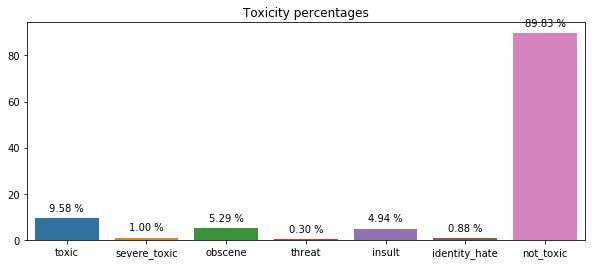

Total records: 159571


In [7]:
cols= train.iloc[:,2:]
cols_len= len(cols)
cols = cols.sum()/len(cols) *100

plt.figure(figsize=(10,4))
ax = sns.barplot(cols.index, cols.values)
ax.set_title('Toxicity percentages')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f} %'.format(height), ha="center") 
    
plt.show()
print('Total records: {:d}'.format(cols_len))

**Insight:** There is an imbalance between toxic and non toxic comments.

**Consequnece:** We shall choose metrics to adress this imbalance

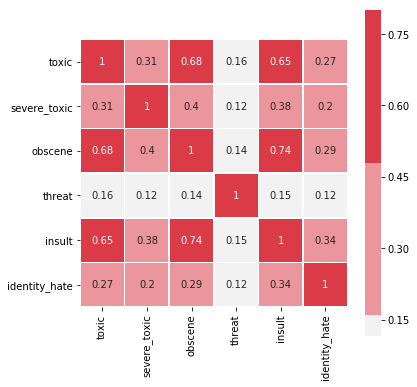

In [8]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(6,6))
corr = train.iloc[:,2:8].corr()
cmap = sns.diverging_palette(240, 10, n=5)
sns.heatmap(corr,  cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, annot=True)

**Insight:** Some correlations are are as low as -0.006, while The highest correlation, 0.75, corresponds to obsene and insult. Perhaps the most remarkable fact is that severe_toxicity is not extremely correlated with other variables like treat!

**Conclusion:** It is reasonable to assume target classes are independent.

# 2.- Preprocessing 

### Spliting comments from labels

In [9]:
comments = list(train.columns)[1]
labels = list(train.columns)[2:8]
comments, labels

('comment_text',
 ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

**Looking at the reviews, one finds comments which need a lot of preprocessing:**

In [10]:
rev=115
print('TRAIN\n')
print(train['comment_text'][rev][:120],'\n')
print('TEST\n')
print(test['comment_text'][rev][:120])

TRAIN

Also I think Vegetable Basket needs it's own Wikipedia page. 

TEST

== scholarly corroboration of folklore == 

 My understanding is that folklore can provide clues to history, medicine, a


The first step in processing the reviews is to make sure that any html tags that appear should be removed. In addition we wish to tokenize our input, that way words such as *entertained* and *entertaining* are considered the same with regard to sentiment analysis.

In [11]:
rep_numbers=re.compile(r'\d+',re.IGNORECASE)

#rep_jumps=re.compile(r'\n+',re.IGNORECASE)

rep_special_chars=re.compile(r'[^a-z\d ]',re.IGNORECASE)

rep_special_chars= re.compile("[^\w']|_")

stemmer = PorterStemmer()
nltk.download("stopwords", quiet=True)

def review_to_words(review):
    
    
    
    #text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    
    #text=rep_jumps.sub(' ', review)
    
    text=rep_special_chars.sub(' ', review)
    
    text = rep_numbers.sub('n', text) # substitute all numbers
    
    
    words = text.split() # Split string into words
    words = [w for w in words if len(w) == len(w.encode())][:100]  
         
    #words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    #words = [stemmer.stem(w) for w in words] # shorter words to stems 
    
    return ' '.join(words)

The `review_to_words` method defined above uses `BeautifulSoup` to remove any html tags that appear and uses the `nltk` package to tokenize the reviews. As a check to ensure we know how everything is working, try applying `review_to_words` to one of the reviews in the training set.

In [12]:
rev=3
print(train['comment_text'][rev],'\n AFTER: \n')
print(review_to_words(train['comment_text'][rev]))

"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.

There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  " 
 AFTER: 

More I can't make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else does first if you have any preferences for formatting style on references o

The function below applies the `review_to_words`  to review in training and testing datasets, and caches results. This way start charge libraries and start notebook here.

In [13]:
test.comment_text = test.comment_text.apply(review_to_words)

In [14]:
test.comment_text[0]

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me Ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time"

In [15]:
test.head(2)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,From RfC The title is fine as it is IMO


In [16]:
test.to_json('./data/test.json', orient='records', lines=True)

In [17]:
train.comment_text = train.comment_text.apply(review_to_words)
train.to_json('./data/train.json', orient='records', lines=True)